# 06 预训练词向量及其应用

本 Notebook 中，我们将介绍预训练词向量的概念，并将其应用到前面实现的各类模型中，以提升模型的性能。

## 6.1 词向量回顾

在 `05Implement.ipynb` 中，我们构建了几种机器学习模型，并通过训练、验证与测试，完成了文本情感分类问题。

我们实现的神经网络框架，包括 MLP、CNN、LSTM 以及 Transformer，其中都包括一个必不可少的组成部分——**词向量层**（Embedding Layer）。

回顾一下，词向量层的主要作用是将离散的词元映射到连续的向量空间中，从而使得模型能够更好地捕捉词与词之间的语义关系。

一般来说，词向量表示中的向量值是随着目标任务的优化过程自动调整的，即将词向量中的向量值看做模型的参数。

## 6.2 预训练词向量

在 `05Implement.ipynb` 的实现中，我们使用了随机初始化的词向量，这意味着词向量的初始值是随机生成的，然后在训练过程中根据任务的损失函数进行调整。

这意味着，词向量在训练开始时并没有任何语义信息，而是通过大量的训练数据逐渐学习到词与词之间的关系。这种方法虽然有效，但无疑需要大量的训练数据和时间。

于是，我们引入了 **预训练词向量**（Pre-trained Word Embeddings）的概念。预训练词向量是指在大规模语料库上预先训练好的词向量表示，这些词向量已经捕捉了丰富的语义信息。

通过使用预训练词向量，我们可以在特定任务上获得更好的性能，尤其是在训练数据有限的情况下。

按照词向量表示与上下文的相关性，预训练词向量可以分为两大类：

1. **静态词向量（Static Word Embeddings）**：每个词元对应一个固定的向量表示，独立于上下文。常用的静态词向量模型包括 Word2Vec、GloVe 和 FastText 等。

2. **动态词向量（Dynamic Word Embeddings）**：词元的向量表示会根据其在句子中的上下文而变化。常用的动态词向量模型包括 ELMo 等。

为了更形象地理解二者的区别，我们来看下面的例子：

> 句子 1：他 亲自 <u>下场</u> 参加 比赛

> 句子 2：竟 落得 这样 的 <u>下场</u>

显然，句子 1 和句子 2 中共同出现的“<u>下场</u>”一词的词义截然不同，并且具有不同的词性。

在静态词向量模型中，“<u>下场</u>”一词无论出现在句子 1 还是句子 2 中，其对应的词向量表示都是相同的，因为静态词向量不考虑上下文信息；

而对于动态词向量模型而言，“<u>下场</u>”一词的词向量表示会根据其所在句子的上下文而变化，从而针对两种不同的语境，得到两个不同的词向量表示，提高了模型对词义的理解能力。

关于预训练词向量的模型构建与训练方法，并不是本项目的重点内容。感兴趣的读者可以参考相关文献和教程进行深入学习。

在本 Notebook 中，我们主要应用静态词向量作为初始化的模型参数，将其集成到深度学习模型中，并在下游任务（即文本情感分类任务）的训练过程中，通过反向传播调整词向量层的参数，这一过程又被称为 **精调**（Fine-tuning）。

## 6.3 导入模块并加载数据

无论使用预训练词向量与否，对模型的训练、验证与测试流程都是相同的。因此，我们可以直接复用 `05Implement.ipynb` 中的通用代码，以及各类模型的定义和相关代码。

然后，加载数据和词汇表。

In [1]:
import torch.nn as nn

from torch.utils.data import DataLoader

from MyModule import (
    load_data, 
    load_vocab, 
    class_weights, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset, 
)


train_data = load_data("data/final/train_index.txt", sep=",", is_indexed=True)
val_data = load_data("data/final/val_index.txt", sep=",", is_indexed=True)
test_data = load_data("data/final/test_index.txt", sep=",", is_indexed=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("data/final/vocab.txt")

## 6.4 预训练词向量的集成

### 6.4.1 预训练词向量的选择

网络上有许多公开的预训练词向量资源可供下载和使用。这里，我们使用腾讯 AI Lab 提供的中文预训练词向量。

腾讯 AI Lab 中文词向量的原版有约 1200 万个中文词汇和短语，词向量的维度为 200 维，文本文件总大小约 15 GB。

我们使用其缩小版本，预训练词向量采用文本文件格式存储，文本文件大小约 190 MB，其中包含约 10 万个常用中文词汇和短语，词向量的维度仍为 200 维。

可以从以下链接下载该缩小版本以及其他大小版本的预训练词向量文件：https://github.com/cliuxinxin/TX-WORD2VEC-SMALL

这里已经事先将预训练词向量文件下载至本地，见本项目目录下 `resources/Word2Vec-100000-small.txt`。

> 您可以通过该下载链接直接下载本 Notebook 所使用的预训练词向量文件：
> 
> 100000-small.txt 10w词 190MB 链接: https://pan.baidu.com/s/1E3olhKipWj71wHO0GIlDqg?pwd=4eat

打开预训练词向量文件后，可以看到如下格式的内容：

可以看到，预训练词向量的基本格式是：
- 每一行表示一个词元及其对应的词向量表示；
- 每一行的第一个元素是词元，后续的元素是该词元对应的词向量表示，各个词向量值之间以空格分隔。每个词向量的维度为200维。

据此，我们可以编写代码，读入预训练词向量。

### 6.4.2 预训练词向量矩阵

那么，如何将得到的预训练词向量集成到深度学习模型中呢？

首先，我们需要构建一个预训练词向量矩阵。方法如下：
- 随机初始化一个形状为 `(vocab_size, embedding_dim)` 的矩阵 `embeddings`，其中 `vocab_size` 是词汇表的大小，`embedding_dim` 是词向量的维度
- 遍历预训练词向量文件中的每一行，提取词元和对应的词向量表示
- 如果词元在词汇表中存在，则用该词元对应的词向量表示替换到 `embeddings` 矩阵中对应的行

这样，当预训练词向量文件遍历结束后，`embeddings` 矩阵就包含了词汇表中所有词元的词向量表示，其中未在预训练词向量文件中出现的词元仍然保持随机初始化的向量表示。

In [2]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建向量矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("resources/Word2Vec-100000-small.txt", vocab, embedding_dim=200)

### 6.4.3 集成预训练词向量到模型中

获得词向量矩阵 `embedding_matrix` 后，如何将其集成到模型中呢？

方法很简单，只需要将 `embedding_matrix` 矩阵作为参数传递给模型类的 `from_pretrained()` 方法即可。

例如，可以按如下方式将其集成到 MLP 模型中：

```python
class MLP(nn.Module):
    def __init__(self, vocab_size, ..., 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        self.embeddingbag = nn.EmbeddingBag.from_pretrained(
            pretrained_embedding_matrix, 
            freeze=freeze
            )

        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(...)
```

注意到 `from_pretrained()` 方法中还有一个 `freeze` 参数，用于指定是否在训练过程中冻结词向量层的参数。

- 如果 `freeze=True`，则表示在训练过程中不更新词向量层的参数，即保持预训练词向量不变；

- 如果 `freeze=False`，则表示在训练过程中允许更新词向量层的参数，从而使模型能够根据特定任务的需求对词向量进行微调。

这里，我们将 `freeze` 参数设置为 `False`，以便在文本情感分类任务中对预训练词向量进行微调，从而提升模型的性能。

### 6.4.4 传参注意事项

最后，还有很重要的一点。

我们设置了 `freeze=False`，这意味着训练过程中允许更新词向量层的参数，即词向量矩阵会在模型训练过程中发生变化。

因此，在构造模型时，不能直接将 `embedding_matrix` 传递给 `from_pretrained()` 方法，而应该传入 `embedding_matrix.clone().detach()`，其中：
- `clone()` 方法用于创建 `embedding_matrix` 的一个副本，确保在训练过程中对词向量矩阵的修改不会影响原始矩阵。
- `detach()` 方法用于将该副本从计算图中分离出来，防止梯度回传到原始矩阵，从而避免对原始矩阵的影响。

## 6.5 模型集成、训练与测试

在上一部分，我们已经完整介绍了预训练词向量矩阵的构建方法及集成于模型的方法。

接下来就是将预训练词向量集成到各类模型中，并在文本情感分类任务中进行训练与测试。

除多传入了预训练词向量矩阵参数外，其余代码均与 `05Implement.ipynb` 中的实现相同，因此不再用文字赘述。

### 6.5.1 多层感知机（集成预训练词向量）

In [3]:
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(35578, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6450	Train Accuracy: 0.7098
    Valid Loss: 0.5872	Valid Accuracy: 0.7382
    Valid Precision: 0.7390	Valid Recall: 0.7382	Valid F1: 0.7326
    ✓ New best validation loss: 0.5872
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5429	Train Accuracy: 0.7638
    Valid Loss: 0.5812	Valid Accuracy: 0.7398
    Valid Precision: 0.7422	Valid Recall: 0.7398	Valid F1: 0.7330
    ✓ New best validation loss: 0.5812
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4935	Train Accuracy: 0.7877
    Valid Loss: 0.5873	Valid Accuracy: 0.7522
    Valid Precision: 0.7498	Valid Recall: 0.7522	Valid F1: 0.7489
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.4560	Train Accuracy: 0.8054
    Valid Loss: 0.5952	Valid Accuracy: 0.7496
    Valid Precision: 0.7480	Valid Recall: 0.7496	Valid F1: 0.7455
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.4221	Train Accuracy: 0.8213
    Valid Loss: 0.6159	Valid Accuracy: 0.7445
    Valid Precision: 0.7452	Valid Recall: 0.7445	Valid F1: 0.7408
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5812


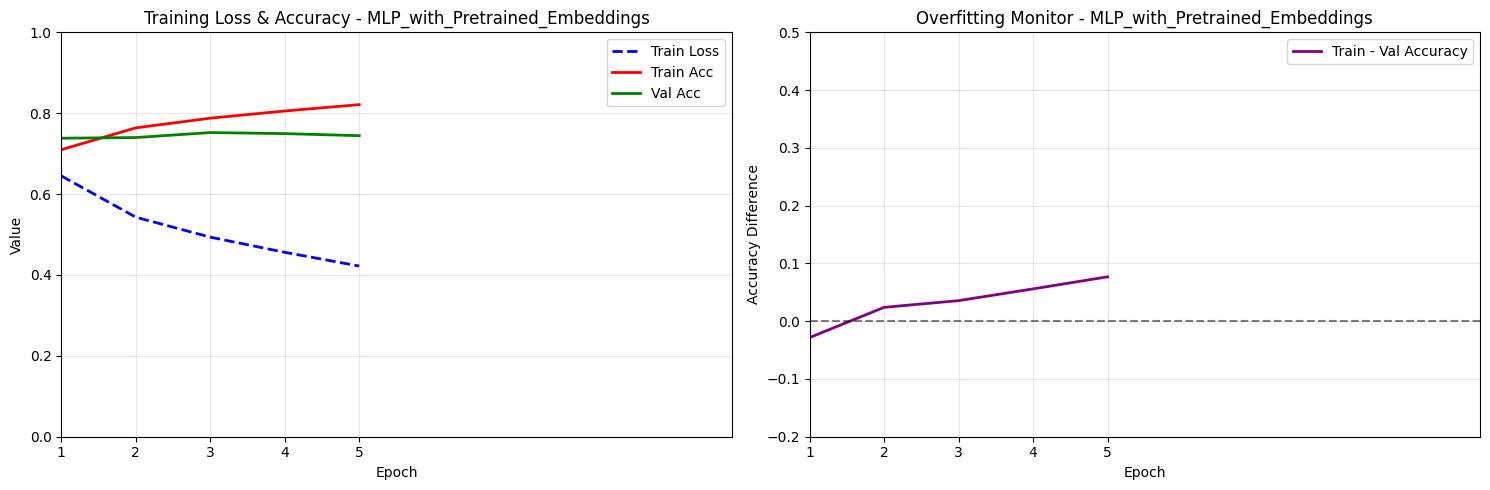


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4221
Final Train Accuracy: 0.8213
Final Val Loss: 0.6159
Final Val Accuracy: 0.7445
Best Val Accuracy: 0.7522 (Epoch 3)
Final Overfitting Gap: 0.0768


In [5]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing:   0%|          | 0/58450 [00:00<?, ?it/s]


TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.7409
Test Precision (weighted): 0.7440
Test Recall (weighted): 0.7409
Test F1 Score (weighted): 0.7342

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8033    0.7164    0.7573     18597
     Neutral     0.7172    0.5272    0.6077     14709
    Positive     0.7158    0.8841    0.7911     25144

    accuracy                         0.7409     58450
   macro avg     0.7454    0.7092    0.7187     58450
weighted avg     0.7440    0.7409    0.7342     58450



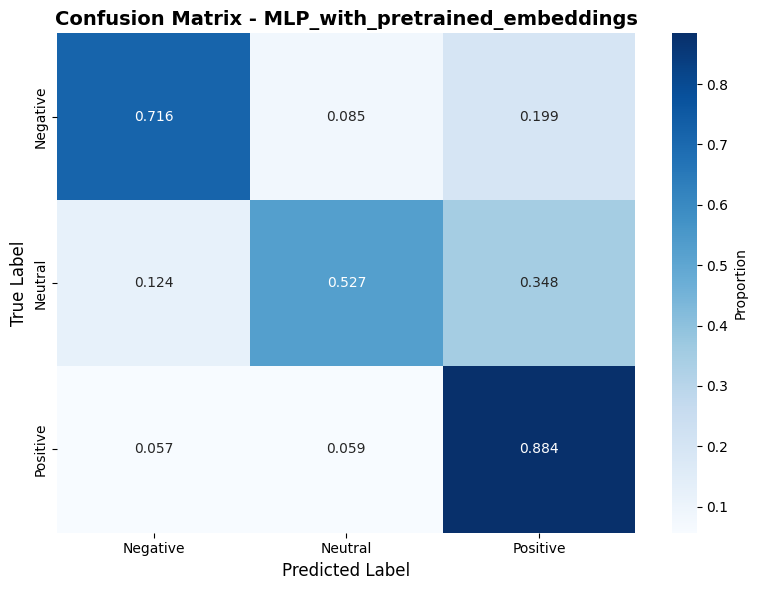


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8033, Recall=0.7164, F1=0.7573, Support=18597
 Neutral: Precision=0.7172, Recall=0.5272, F1=0.6077, Support=14709
Positive: Precision=0.7158, Recall=0.8841, F1=0.7911, Support=25144


In [6]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [7]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7409
  - 测试F1分数: 0.7342
  - 记录时间: 2025-11-27 11:41:59
  - 总记录数: 65


### 6.5.2 卷积神经网络（集成预训练词向量）

In [8]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(35578, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [9]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6100	Train Accuracy: 0.7251
    Valid Loss: 0.5991	Valid Accuracy: 0.7439
    Valid Precision: 0.7472	Valid Recall: 0.7439	Valid F1: 0.7386
    ✓ New best validation loss: 0.5991
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5207	Train Accuracy: 0.7748
    Valid Loss: 0.5720	Valid Accuracy: 0.7562
    Valid Precision: 0.7557	Valid Recall: 0.7562	Valid F1: 0.7537
    ✓ New best validation loss: 0.5720
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4711	Train Accuracy: 0.7999
    Valid Loss: 0.5637	Valid Accuracy: 0.7524
    Valid Precision: 0.7539	Valid Recall: 0.7524	Valid F1: 0.7448
    ✓ New best validation loss: 0.5637
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.4318	Train Accuracy: 0.8187
    Valid Loss: 0.5647	Valid Accuracy: 0.7485
    Valid Precision: 0.7512	Valid Recall: 0.7485	Valid F1: 0.7438
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.3976	Train Accuracy: 0.8353
    Valid Loss: 0.5791	Valid Accuracy: 0.7480
    Valid Precision: 0.7530	Valid Recall: 0.7480	Valid F1: 0.7480
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.3668	Train Accuracy: 0.8486
    Valid Loss: 0.5922	Valid Accuracy: 0.7487
    Valid Precision: 0.7517	Valid Recall: 0.7487	Valid F1: 0.7487
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5637


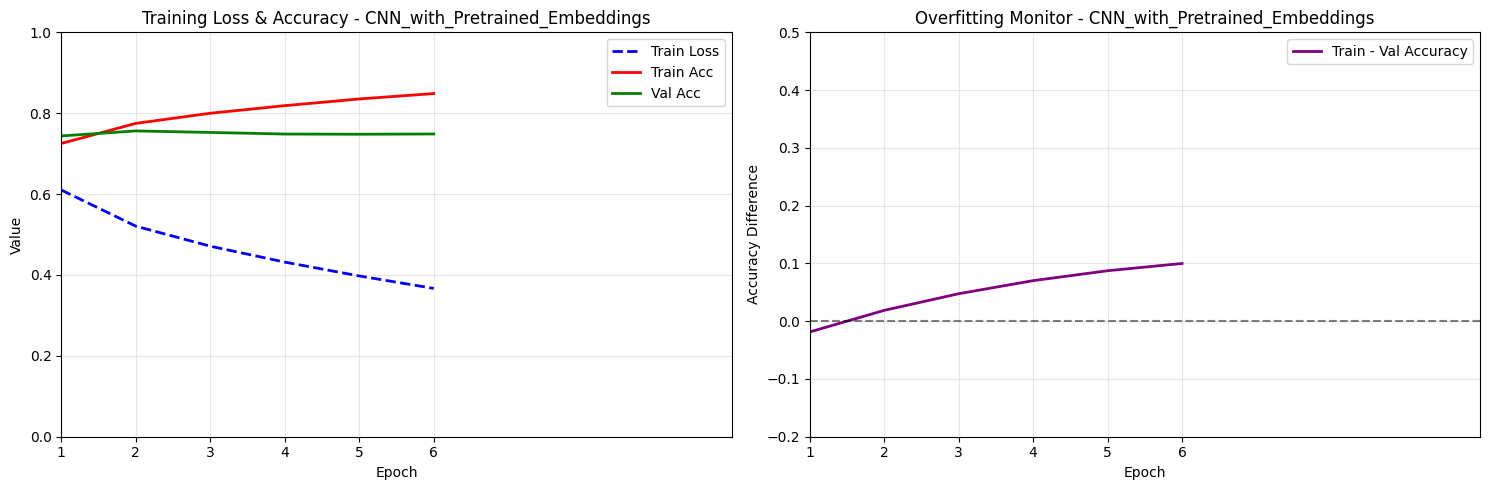


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3668
Final Train Accuracy: 0.8486
Final Val Loss: 0.5922
Final Val Accuracy: 0.7487
Best Val Accuracy: 0.7562 (Epoch 2)
Final Overfitting Gap: 0.0999


In [10]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing:   0%|          | 0/58450 [00:00<?, ?it/s]


TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7468
Test Precision (weighted): 0.7506
Test Recall (weighted): 0.7468
Test F1 Score (weighted): 0.7367

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7925    0.7614    0.7767     18597
     Neutral     0.7503    0.4743    0.5812     14709
    Positive     0.7197    0.8955    0.7980     25144

    accuracy                         0.7468     58450
   macro avg     0.7542    0.7104    0.7186     58450
weighted avg     0.7506    0.7468    0.7367     58450



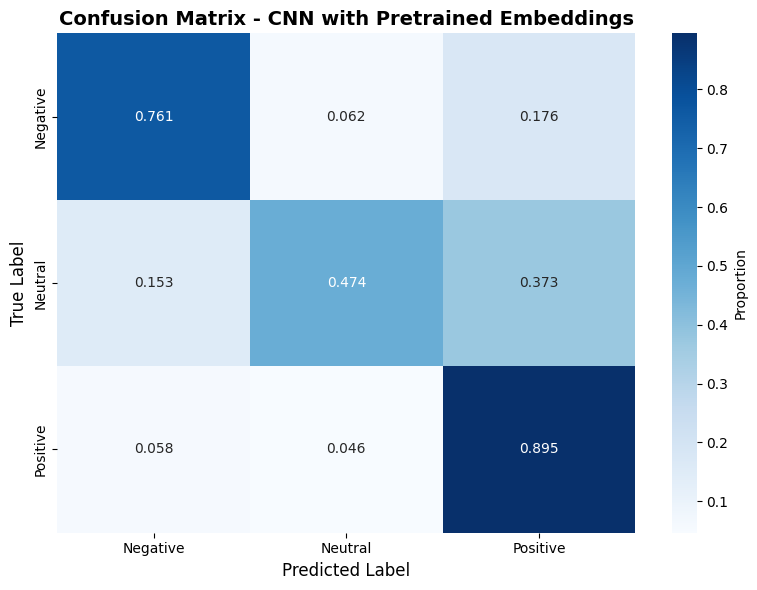


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7925, Recall=0.7614, F1=0.7767, Support=18597
 Neutral: Precision=0.7503, Recall=0.4743, F1=0.5812, Support=14709
Positive: Precision=0.7197, Recall=0.8955, F1=0.7980, Support=25144


In [11]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [12]:
# 保存CNN训练结果
save_training_results(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN with Pretrained Embeddings (CNN)
  - 实际训练轮数: 6
  - 测试准确率: 0.7468
  - 测试F1分数: 0.7367
  - 记录时间: 2025-11-27 11:46:56
  - 总记录数: 66


### 6.5.3 长短期记忆网络（集成预训练词向量）

In [13]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(35578, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6001	Train Accuracy: 0.7323
    Valid Loss: 0.5364	Valid Accuracy: 0.7644
    Valid Precision: 0.7621	Valid Recall: 0.7644	Valid F1: 0.7590
    ✓ New best validation loss: 0.5364
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.4813	Train Accuracy: 0.7931
    Valid Loss: 0.5250	Valid Accuracy: 0.7712
    Valid Precision: 0.7697	Valid Recall: 0.7712	Valid F1: 0.7691
    ✓ New best validation loss: 0.5250
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4039	Train Accuracy: 0.8289
    Valid Loss: 0.5482	Valid Accuracy: 0.7715
    Valid Precision: 0.7706	Valid Recall: 0.7715	Valid F1: 0.7709
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.3321	Train Accuracy: 0.8617
    Valid Loss: 0.6086	Valid Accuracy: 0.7610
    Valid Precision: 0.7631	Valid Recall: 0.7610	Valid F1: 0.7599
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.2660	Train Accuracy: 0.8901
    Valid Loss: 0.6792	Valid Accuracy: 0.7592
    Valid Precision: 0.7580	Valid Recall: 0.7592	Valid F1: 0.7580
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5250


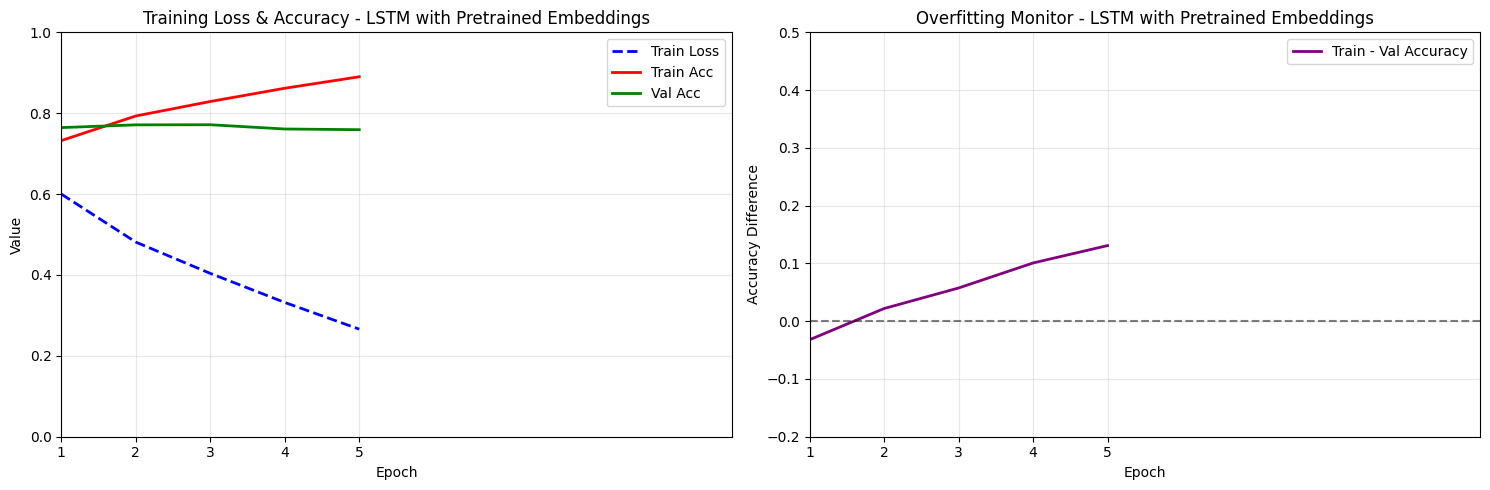


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2660
Final Train Accuracy: 0.8901
Final Val Loss: 0.6792
Final Val Accuracy: 0.7592
Best Val Accuracy: 0.7715 (Epoch 3)
Final Overfitting Gap: 0.1309


In [15]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing:   0%|          | 0/58450 [00:00<?, ?it/s]


TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7702
Test Precision (weighted): 0.7690
Test Recall (weighted): 0.7702
Test F1 Score (weighted): 0.7682

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8208    0.7654    0.7922     18597
     Neutral     0.6834    0.6261    0.6535     14709
    Positive     0.7807    0.8579    0.8175     25144

    accuracy                         0.7702     58450
   macro avg     0.7616    0.7498    0.7544     58450
weighted avg     0.7690    0.7702    0.7682     58450



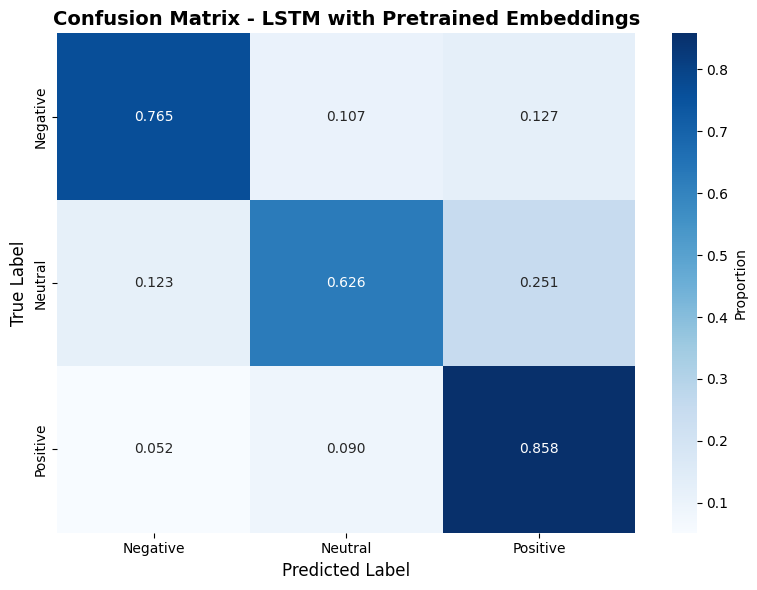


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8208, Recall=0.7654, F1=0.7922, Support=18597
 Neutral: Precision=0.6834, Recall=0.6261, F1=0.6535, Support=14709
Positive: Precision=0.7807, Recall=0.8579, F1=0.8175, Support=25144


In [16]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [17]:
# 保存LSTM训练结果
save_training_results(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM with Pretrained Embeddings (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7702
  - 测试F1分数: 0.7682
  - 记录时间: 2025-11-27 11:53:11
  - 总记录数: 67


### 6.5.4 Transformer（集成预训练词向量）

In [18]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35578, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [19]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
# optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(transformer_pre_emb.parameters(), lr=2e-5, weight_decay=1e-3)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.7936	Train Accuracy: 0.6104
    Valid Loss: 0.6649	Valid Accuracy: 0.6985
    Valid Precision: 0.6981	Valid Recall: 0.6985	Valid F1: 0.6949
    ✓ New best validation loss: 0.6649
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.6913	Train Accuracy: 0.6827
    Valid Loss: 0.6435	Valid Accuracy: 0.7198
    Valid Precision: 0.7198	Valid Recall: 0.7198	Valid F1: 0.7198
    ✓ New best validation loss: 0.6435
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.6592	Train Accuracy: 0.7005
    Valid Loss: 0.6170	Valid Accuracy: 0.7181
    Valid Precision: 0.7201	Valid Recall: 0.7181	Valid F1: 0.7121
    ✓ New best validation loss: 0.6170
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.6381	Train Accuracy: 0.7123
    Valid Loss: 0.6041	Valid Accuracy: 0.7324
    Valid Precision: 0.7288	Valid Recall: 0.7324	Valid F1: 0.7275
    ✓ New best validation loss: 0.6041
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.6215	Train Accuracy: 0.7206
    Valid Loss: 0.6072	Valid Accuracy: 0.7387
    Valid Precision: 0.7376	Valid Recall: 0.7387	Valid F1: 0.7376
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.6093	Train Accuracy: 0.7275
    Valid Loss: 0.5849	Valid Accuracy: 0.7386
    Valid Precision: 0.7371	Valid Recall: 0.7386	Valid F1: 0.7353
    ✓ New best validation loss: 0.5849
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.5982	Train Accuracy: 0.7320
    Valid Loss: 0.5847	Valid Accuracy: 0.7394
    Valid Precision: 0.7380	Valid Recall: 0.7394	Valid F1: 0.7330
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 8/10
    Train Loss: 0.5894	Train Accuracy: 0.7365
    Valid Loss: 0.5804	Valid Accuracy: 0.7372
    Valid Precision: 0.7428	Valid Recall: 0.7372	Valid F1: 0.7368
    ✓ New best validation loss: 0.5804
--------------------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 9/10
    Train Loss: 0.5808	Train Accuracy: 0.7407
    Valid Loss: 0.5782	Valid Accuracy: 0.7486
    Valid Precision: 0.7456	Valid Recall: 0.7486	Valid F1: 0.7459
    ✓ New best validation loss: 0.5782
--------------------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/8528 [00:00<?, ?it/s]

Epoch 10/10
    Train Loss: 0.5732	Train Accuracy: 0.7454
    Valid Loss: 0.5741	Valid Accuracy: 0.7489
    Valid Precision: 0.7475	Valid Recall: 0.7489	Valid F1: 0.7479
    ✓ New best validation loss: 0.5741
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7739    0.7553    0.7645     18607
     Neutral     0.6567    0.6297    0.6429     14727
    Positive     0.7812    0.8139    0.7972     25138

    accuracy                         0.7489     58472
   macro avg     0.7373    0.7330    0.7349     58472
weighted avg     0.7475    0.7489    0.7479     58472



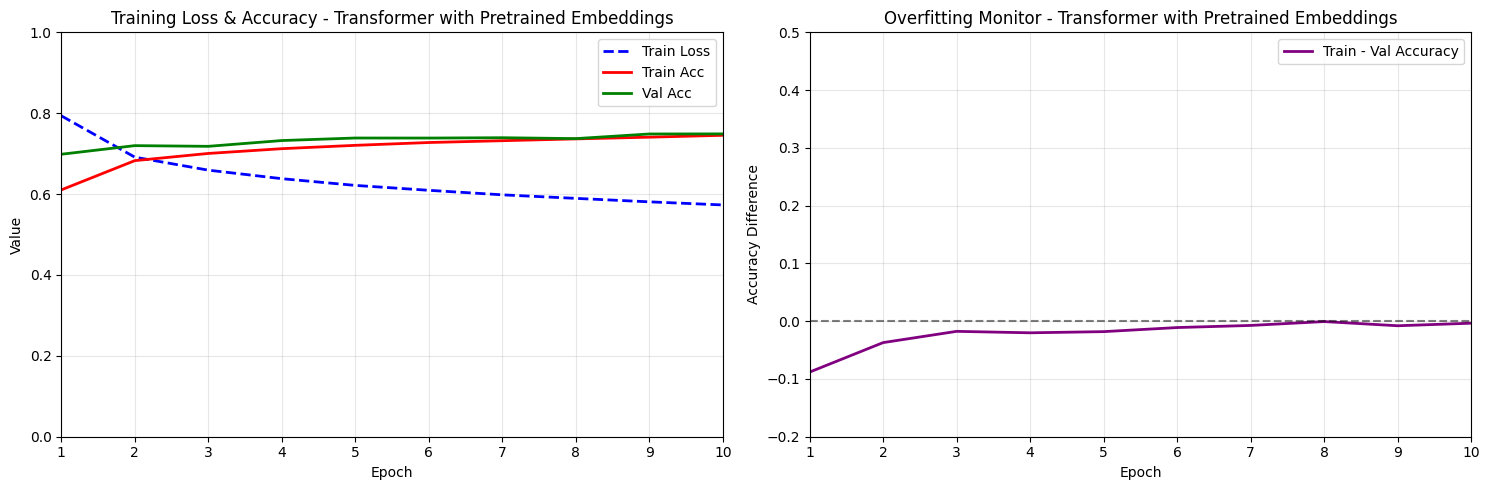


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.5732
Final Train Accuracy: 0.7454
Final Val Loss: 0.5741
Final Val Accuracy: 0.7489
Best Val Accuracy: 0.7489 (Epoch 10)
Final Overfitting Gap: -0.0035


In [20]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing:   0%|          | 0/58450 [00:00<?, ?it/s]


TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.7470
Test Precision (weighted): 0.7458
Test Recall (weighted): 0.7470
Test F1 Score (weighted): 0.7461

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7735    0.7501    0.7616     18597
     Neutral     0.6543    0.6295    0.6417     14709
    Positive     0.7788    0.8136    0.7958     25144

    accuracy                         0.7470     58450
   macro avg     0.7355    0.7310    0.7330     58450
weighted avg     0.7458    0.7470    0.7461     58450



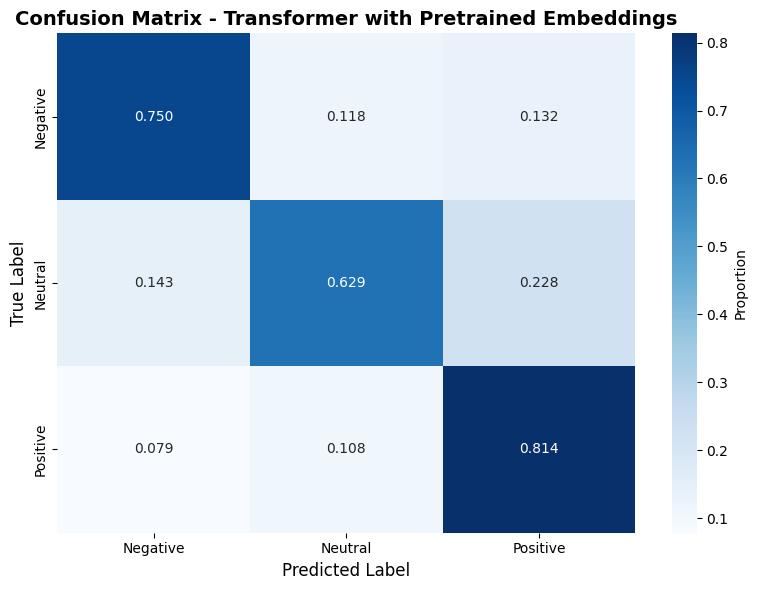


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7735, Recall=0.7501, F1=0.7616, Support=18597
 Neutral: Precision=0.6543, Recall=0.6295, F1=0.6417, Support=14709
Positive: Precision=0.7788, Recall=0.8136, F1=0.7958, Support=25144


In [21]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)

In [22]:
# 保存Transformer训练结果
save_training_results(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer with Pretrained Embeddings (Transformer)
  - 实际训练轮数: 10
  - 测试准确率: 0.7470
  - 测试F1分数: 0.7461
  - 记录时间: 2025-11-27 12:06:33
  - 总记录数: 68
